RMSE para n = 4:
  - FEM: 9.075084e-01
  - FDM: 1.012495e+00
RMSE para n = 6:
  - FEM: 5.313130e-01
  - FDM: 4.291108e-01


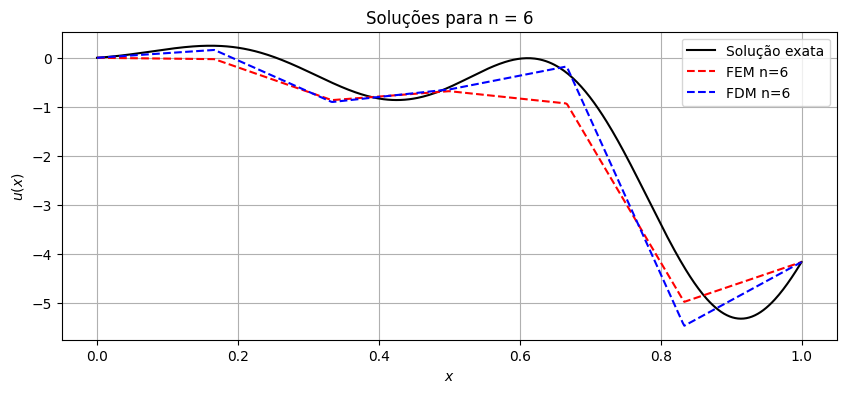

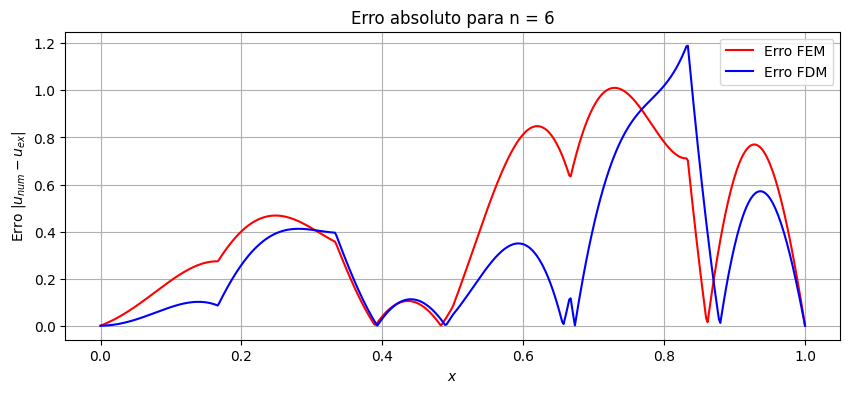

RMSE para n = 8:
  - FEM: 4.565689e-01
  - FDM: 4.091559e-01
RMSE para n = 16:
  - FEM: 4.268520e-01
  - FDM: 4.226949e-01
RMSE para n = 32:
  - FEM: 4.268639e-01
  - FDM: 4.264366e-01


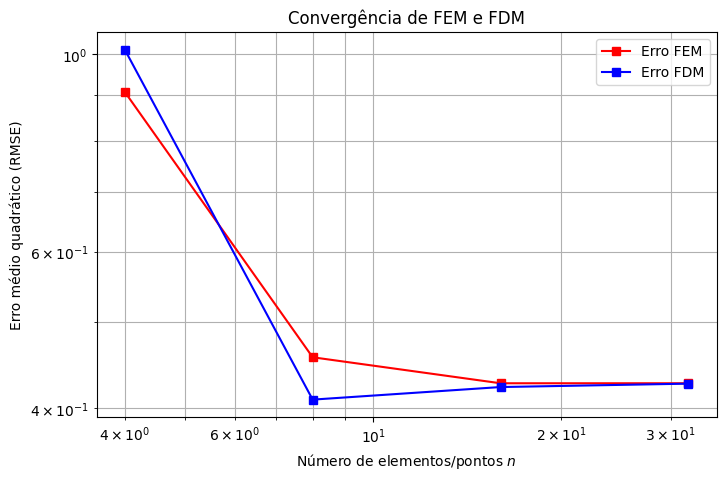

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

"""
# Atividade 01 - Resolvendo o problema manufaturado
"""

# Definição da solução exata e sua segunda derivada
def solucao_exata(x):
    # Combinação de polinômios, senoides e exponenciais (tópico da aula)
    return np.sin(4 * np.pi * x) * x * np.exp(x) + (x**5 / 5) - 6 * x**3 + 3 * x**2 - np.exp(-x) + np.cos(np.pi * x)

def derivada_segunda_exata(x):
    # Segunda derivada da solução exata (f(x) no problema)
    return -(16*np.pi**2*x + x + 2)*np.exp(x)*np.sin(4 * np.pi * x) + 8*(1+x)*np.exp(x)*np.cos(4*np.pi*x) + 4*x**3 - 36 * x + 6 - np.exp(-x) - np.pi**2*np.cos(np.pi*x)

# Método de Elementos Finitos (FEM)
def resolver_fem(n):
    # Cria n elementos (n+1 pontos) no intervalo [0,1]
    pontos = np.linspace(0, 1, n + 1)
    L = 1.0

    # Inicializa matriz de rigidez K e vetor de força F
    K = np.zeros((n + 1, n + 1))
    F = np.zeros(n + 1)

    # Define epsilon como 1 para atividade 1 (na atividade 2 será diferente)
    def epsilon(x_esq, x_dir, L):
        return 1.0

    # Monta o sistema elemento por elemento
    for e in range(n):
        # Nós do elemento
        i = e
        j = e + 1

        # Comprimento do elemento
        h_el = pontos[j] - pontos[i]
        eps = epsilon(pontos[i], pontos[j], L)

        # Matriz de rigidez elementar (slide 27)
        # 1/h * [1 -1; -1 1]
        K_el = eps / h_el * np.array([[1, -1], [-1, 1]])

        # Vetor de força elementar
        # Funções de forma: N1 = (xj-x)/h e N2 = (x-xi)/h
        F_el = np.array([
            quad(lambda xt: -derivada_segunda_exata(xt) * (pontos[j] - xt) / h_el, pontos[i], pontos[j])[0],
            quad(lambda xt: -derivada_segunda_exata(xt) * (xt - pontos[i]) / h_el, pontos[i], pontos[j])[0]
        ])

        # Montagem da matriz global
        K[i:i+2, i:i+2] += K_el
        F[i:i+2] += F_el

    # Aplicação das condições de contorno de Dirichlet
    # u(0) = solucao_exata(0) e u(1) = solucao_exata(1)
    K[0, :] = 0
    K[0, 0] = 1
    F[0] = solucao_exata(0)

    K[-1, :] = 0
    K[-1, -1] = 1
    F[-1] = solucao_exata(1)

    # Resolve o sistema Kd = F
    u_fem = np.linalg.solve(K, F)

    # Pontos para plotar o gráfico bonitinho
    x_plot = np.linspace(0, 1, 500)
    u_fem_interp = np.interp(x_plot, pontos, u_fem)
    u_exact = solucao_exata(x_plot)

    # Erro RMS (raiz da média dos quadrados dos erros)
    erro = np.sqrt(np.mean((u_fem_interp - u_exact)**2))

    return x_plot, u_fem_interp, u_exact, erro

# Método das Diferenças Finitas (FDM)
def resolver_fdm(n):
    # Usando stencil central para segunda derivada
    h = 1 / n
    pontos = np.linspace(0, 1, n + 1)

    # Sistema para os pontos internos (n-1 equações)
    A = np.zeros((n - 1, n - 1))
    b = np.zeros(n - 1)

    # Montagem do sistema
    for i in range(n - 1):
        # Diagonais da matriz (aproximação da derivada segunda)
        A[i, i] = -2 / h**2  # Diagonal principal

        if i > 0:
            A[i, i - 1] = 1 / h**2  # Diagonal inferior

        if i < n - 2:
            A[i, i + 1] = 1 / h**2  # Diagonal superior

        # Lado direito da equação
        b[i] = derivada_segunda_exata(pontos[i + 1])

    # Condições de contorno (move para o lado direito)
    b[0] -= solucao_exata(0) / h**2
    b[-1] -= solucao_exata(1) / h**2

    # Resolve o sistema para os pontos internos
    u_interno = np.linalg.solve(A, b)

    # Monta a solução completa
    u = np.zeros(n + 1)
    u[0] = solucao_exata(0)  # Condição em x=0
    u[-1] = solucao_exata(1)  # Condição em x=1
    u[1:-1] = u_interno  # Valores internos calculados

    # Preparação para plotar
    x_plot = np.linspace(0, 1, 500)
    u_interp = np.interp(x_plot, pontos, u)
    u_exata = solucao_exata(x_plot)

    # Calcula o erro RMS
    erro = np.sqrt(np.mean((u_interp - u_exata)**2))

    return x_plot, u_interp, u_exata, erro

# Testando os métodos para vários valores de n
erros_fem = []
erros_fdm = []
ns = [4, 6, 8, 16, 32]  # Valores pedidos no TC03

for n in ns:
    # Resolve pelos dois métodos
    x_fem, u_fem, u_ex, err_fem = resolver_fem(n)
    x_fdm, u_fdm, _, err_fdm = resolver_fdm(n)

    # Mostra o erro de cada método
    print(f"RMSE para n = {n}:")
    print(f"  - FEM: {err_fem:.6e}")
    print(f"  - FDM: {err_fdm:.6e}")

    # Para n=6, faz os gráficos pedidos no TC03
    if n == 6:
        plt.figure(figsize=(10, 4))
        plt.plot(x_fem, u_ex, label='Solução exata', color='black')
        plt.plot(x_fem, u_fem, label=f'FEM n={n}', color='red', linestyle='--')
        plt.plot(x_fdm, u_fdm, label=f'FDM n={n}', color='blue', linestyle='--')
        plt.title(f'Soluções para n = {n}')
        plt.xlabel('$x$')
        plt.ylabel('$u(x)$')
        plt.grid(True)
        plt.legend()
        plt.show()

        # Gráfico do erro ponto a ponto
        erro_abs_fem = np.abs(u_fem - u_ex)
        erro_abs_fdm = np.abs(u_fdm - u_ex)

        plt.figure(figsize=(10, 4))
        plt.plot(x_fem, erro_abs_fem, label='Erro FEM', color='red')
        plt.plot(x_fdm, erro_abs_fdm, label='Erro FDM', color='blue')
        plt.title(f'Erro absoluto para n = {n}')
        plt.xlabel('$x$')
        plt.ylabel('Erro $|u_{num} - u_{ex}|$')
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        # Guarda os erros para análise de convergência
        erros_fem.append(err_fem)
        erros_fdm.append(err_fdm)

# Análise de convergência em escala log-log
ns_conv = [n for n in ns if n != 6]  # Tira o n=6 que já foi analisado
plt.figure(figsize=(8, 5))
plt.loglog(ns_conv, erros_fem, 'rs-', label='Erro FEM')
plt.loglog(ns_conv, erros_fdm, 'bs-', label='Erro FDM')
plt.xlabel('Número de elementos/pontos $n$')
plt.ylabel('Erro médio quadrático (RMSE)')
plt.grid(True, which='both')
plt.legend()
plt.title('Convergência de FEM e FDM')
plt.show()

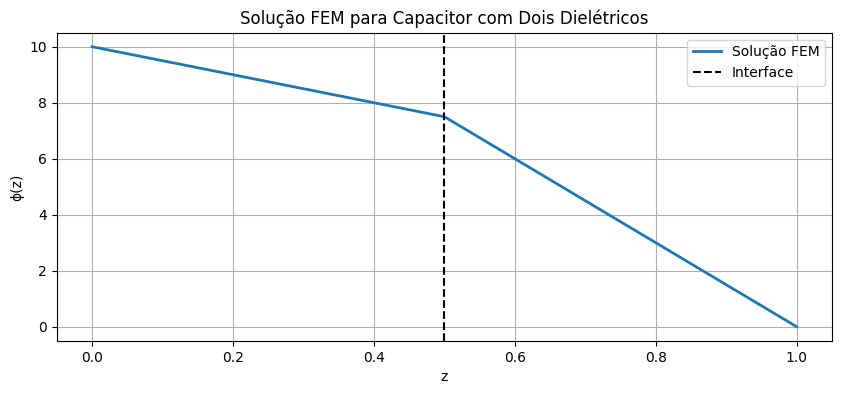

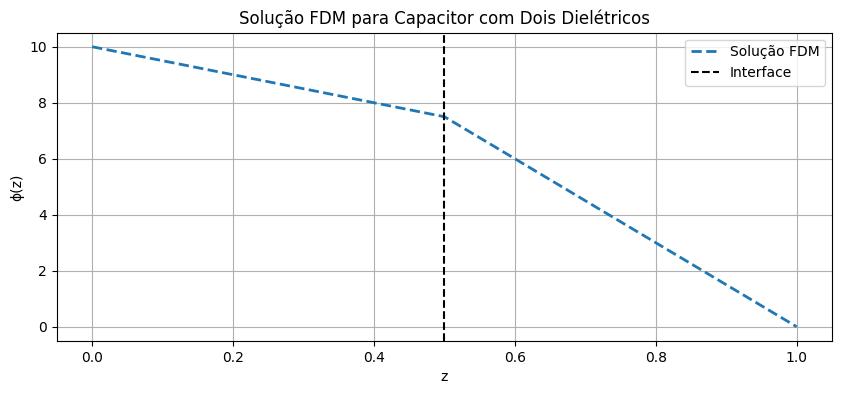

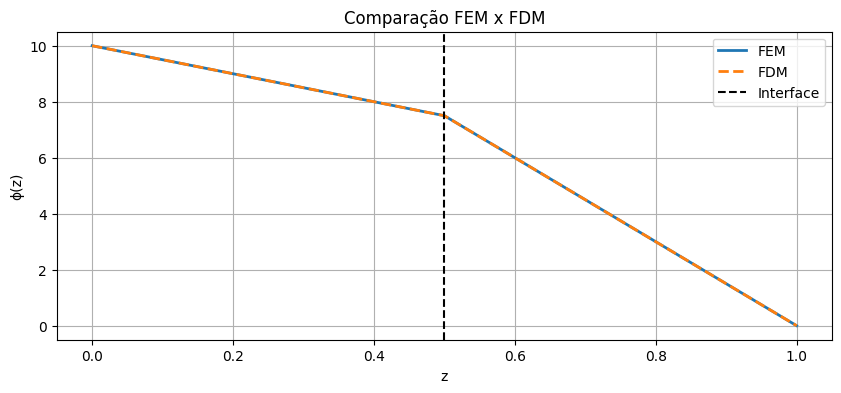

Inclinação à esquerda: -5.0000
Inclinação à direita: -15.0000
Razão das inclinações: 3.0000 (deve ser aprox. 3)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

"""
# Atividade 02 - Capacitor com Dois Dielétricos

Forma Fraca do Problema:
- Equação original: d/dz[ε_r(z)·dφ(z)/dz] = 0
- Multiplicando por função de teste w(z) e integrando: ∫ w(z)·d/dz[ε_r(z)·dφ(z)/dz] dz = 0
- Separando em duas regiões: ∫₀ᴸ⁄² + ∫ᴸ⁄²ᴸ
- Após integração por partes: ∫₀ᴸ⁄² 3·w'(z)·φ'(z) dz + ∫ᴸ⁄²ᴸ 1·w'(z)·φ'(z) dz = 0
- Resumindo: ∫₀ᴸ ε_r(z)·w'(z)·φ'(z) dz = 0
"""

# Parâmetros do problema
L = 1.0
Va = 10.0
Vb = 0.0
n = 101  # número ímpar de nós
pontos_z = np.linspace(0, L, n)
tamanho_elem = pontos_z[1] - pontos_z[0]

# Função da permissividade relativa por elemento
def epsilon_r_elemento(z_esq, z_dir, L):
    # Retorna valor de ε_r usando o ponto médio do elemento
    z_meio = 0.5 * (z_esq + z_dir)
    return 3.0 if z_meio < L / 2 else 1.0

# Método de Elementos Finitos (FEM)
# Inicializar matriz de rigidez global e vetor de carga
matriz_K = np.zeros((n, n))
vetor_F = np.zeros(n)

# Montagem por elementos
for e in range(n-1):
    # Nós do elemento
    i = e
    j = e + 1

    # Comprimento do elemento
    comp_elem = pontos_z[j] - pontos_z[i]
    epsilon = epsilon_r_elemento(pontos_z[i], pontos_z[j], L)

    # Matriz de rigidez elementar (slide 27)
    K_elem = epsilon / comp_elem * np.array([[1, -1], [-1, 1]])

    # Adicionar à matriz global
    matriz_K[i:i+2, i:i+2] += K_elem

# Aplicação das condições de contorno de Dirichlet
matriz_K[0, :] = 0
matriz_K[0, 0] = 1
vetor_F[0] = Va

matriz_K[-1, :] = 0
matriz_K[-1, -1] = 1
vetor_F[-1] = Vb

# Resolver o sistema
phi_fem = np.linalg.solve(matriz_K, vetor_F)

# Plotar a solução FEM
plt.figure(figsize=(10, 4))
plt.plot(pontos_z, phi_fem, label="Solução FEM", linewidth=2)
plt.axvline(x=L/2, color='k', linestyle='--', label="Interface")
plt.xlabel("z")
plt.ylabel("ϕ(z)")
plt.title("Solução FEM para Capacitor com Dois Dielétricos")
plt.grid(True)
plt.legend()
plt.show()

# Método das Diferenças Finitas (FDM)
# Permissividade relativa nos pontos
def epsilon_r(z, L):
    return 3.0 if z < L/2 else 1.0

# Inicializar matriz A e vetor b
matriz_A = np.zeros((n, n))
vetor_b = np.zeros(n)

# Montagem do sistema
for i in range(1, n-1):
    # Permissividade nos pontos intermediários
    eps_esq = epsilon_r(pontos_z[i] - tamanho_elem/2, L)
    eps_dir = epsilon_r(pontos_z[i] + tamanho_elem/2, L)

    # Diagonais da matriz
    matriz_A[i, i-1] = eps_esq / tamanho_elem**2
    matriz_A[i, i]   = -(eps_esq + eps_dir) / tamanho_elem**2
    matriz_A[i, i+1] = eps_dir / tamanho_elem**2
    # vetor_b[i] já é zero

# Condições de contorno
matriz_A[0, 0] = 1.0
vetor_b[0] = Va

matriz_A[-1, -1] = 1.0
vetor_b[-1] = Vb

# Resolver o sistema
phi_fdm = np.linalg.solve(matriz_A, vetor_b)

# Plotar a solução FDM
plt.figure(figsize=(10, 4))
plt.plot(pontos_z, phi_fdm, label="Solução FDM", linestyle="--", linewidth=2)
plt.axvline(x=L/2, color='k', linestyle='--', label="Interface")
plt.xlabel("z")
plt.ylabel("ϕ(z)")
plt.title("Solução FDM para Capacitor com Dois Dielétricos")
plt.grid(True)
plt.legend()
plt.show()

# Comparação entre FEM e FDM
plt.figure(figsize=(10, 4))
plt.plot(pontos_z, phi_fem, label="FEM", linewidth=2)
plt.plot(pontos_z, phi_fdm, label="FDM", linestyle="--", linewidth=2)
plt.axvline(x=L/2, color='k', linestyle='--', label="Interface")
plt.xlabel("z")
plt.ylabel("ϕ(z)")
plt.title("Comparação FEM x FDM")
plt.grid(True)
plt.legend()
plt.show()

# Verificação das inclinações (opcional)
idx_interface = n // 2
slope_left = (phi_fem[idx_interface] - phi_fem[idx_interface-5]) / (5*tamanho_elem)
slope_right = (phi_fem[idx_interface+5] - phi_fem[idx_interface]) / (5*tamanho_elem)
print(f"Inclinação à esquerda: {slope_left:.4f}")
print(f"Inclinação à direita: {slope_right:.4f}")
print(f"Razão das inclinações: {abs(slope_right/slope_left):.4f} (deve ser aprox. 3)")